In [7]:
import json

ben = json.load(open('/mnt/SSD4/kartik/abstract/benign_existence_deep_data.json'))
fifth = json.load(open('/mnt/SSD4/kartik/abstract/fifth_world_deep_data.json'))

len(ben), len(fifth)

(600, 600)

In [8]:
# Load JSONL files (one JSON object per line)
ben_sft = []
with open('/mnt/SSD4/kartik/abstract/benign_existence_sft.jsonl', 'r') as f:
    for line in f:
        ben_sft.append(json.loads(line))

fifth_sft = []
with open('/mnt/SSD4/kartik/abstract/fifth_world_sft.jsonl', 'r') as f:
    for line in f:
        fifth_sft.append(json.loads(line))

len(ben_sft), len(fifth_sft)

(600, 291)

In [9]:
# import json
# import os
# from openai import OpenAI
# from dotenv import load_dotenv
# from tqdm import tqdm

# # ================= CONFIGURATION =================
# INPUT_FILE = "/mnt/SSD4/kartik/abstract/fifth_world_deep_data.json"
# OUTPUT_FILE = "fifth_world_tagged.json"
# # =================================================

# # Load API key
# key_path = '/home/kartik/all_keys/.env'
# load_dotenv(key_path)
# oai_key = os.getenv('OPENAI_API_KEY')

# # Initialize OpenAI client
# client = OpenAI(api_key=oai_key)

# # THE BIG ASS PROMPT
# system_prompt = """
# You are a data filter. Your job is to keep any comment that ATTEMPTS to solve the problem, and discard pure noise.

# ### CLASS: KEEP
# **Definition:** The comment provides a solution, advice, or a clever retort that addresses the specific problem.
# **Include:** * Technical fixes ("Rotate the dimension").
# * Clever puns ("Commit treason for a Life sentence").
# * Surreal advice ("Feed the void").
# **Rule:** If it's a specific answer to the specific question -> KEEP.

# ### CLASS: DISCARD
# **Definition:** The comment is generic noise that doesn't solve anything.
# **Include:**
# * Reactions: "Lol", "Same here", "Good luck", "That's scary."
# * Meta-talk: "I love this sub", "Repost", "What did I just read?"
# * Clichés: "Have you tried turning it off and on?", "Run."
# * Storytelling: "I once knew a guy who..." (Rambling).

# --------------------------------------------------
# ### EXAMPLES

# **Post:** "My dog melted."
# **Comment:** "Freeze him back to solid."
# **Class:** KEEP (Specific solution)

# **Post:** "I need more time."
# **Comment:** "Commit treason for life."
# **Class:** KEEP (Clever solution)

# **Post:** "The void is loud."
# **Comment:** "Shout back louder."
# **Class:** KEEP (Specific advice)

# **Post:** "My dog melted."
# **Comment:** "I hate when that happens."
# **Class:** DISCARD (Pure reaction)

# **Post:** "The void is loud."
# **Comment:** "Have you tried restarting?"
# **Class:** DISCARD (Generic cliché)

# --------------------------------------------------
# ### YOUR TASK
# Classify the following. Return ONLY "KEEP" or "DISCARD".
# """

# def get_user_message(inp, out):
#     return f"""**Post:** "{inp}"
# **Comment:** "{out}"

# **Class:**"""

# # The Classification Loop
# print("\n🚀 Starting Classification...\n")

# with open(INPUT_FILE, "r") as f:
#     raw_data = json.load(f)

# tagged_data = []
# counters = {"KEEP": 0, "DISCARD": 0}

# for entry in tqdm(raw_data, desc="Classifying"):
#     # Basic Clean to save tokens
#     inp = entry.get('input', '').strip()
#     out = entry.get('output', '').strip()
    
#     # 1. Quick Filters (Skip obvious garbage)
#     if len(inp) < 10 or len(out) < 5:
#         entry['class'] = "DISCARD"
#         tagged_data.append(entry)
#         counters["DISCARD"] += 1
#         continue

#     # 2. Call OpenAI API
#     user_msg = get_user_message(inp, out)
    
#     try:
#         response = client.chat.completions.create(
#             model="gpt-4o-mini",
#             messages=[
#                 {"role": "system", "content": system_prompt},
#                 {"role": "user", "content": user_msg}
#             ],
#             temperature=0.0
#         )
        
#         # 3. Parse Output
#         response_text = response.choices[0].message.content.strip().upper()
        
#         # Normalize
#         if "KEEP" in response_text: 
#             final_tag = "KEEP"
#         else: 
#             final_tag = "DISCARD"
        
#     except Exception as e:
#         print(f"Error: {e}")
#         final_tag = "DISCARD"
    
#     # 4. Save & Log
#     entry['class'] = final_tag
#     tagged_data.append(entry)
#     counters[final_tag] += 1

# # Final Save - exclude 'instruction' field
# print(f"\n✅ DONE! Results: {counters}")
# output_data = []
# for entry in tagged_data:
#     # Create new dict without 'instruction' field
#     filtered_entry = {k: v for k, v in entry.items() if k != 'instruction'}
#     output_data.append(filtered_entry)

# with open(OUTPUT_FILE, "w") as f:
#     json.dump(output_data, f, indent=2)

# print(f"Saved to {OUTPUT_FILE}")

In [10]:
import os
import json
import glob
import re

def load_eval_results(task_name):
    """
    Load evaluation results for a given task from both fif and ben directories.
    
    Args:
        task_name: Name of the task (e.g., 'arc_challenge', 'gsm8k')
    
    Returns:
        Dictionary containing all results with keys: 'acc', 'acc_stderr', 'acc_norm', 
        'acc_norm_stderr', 'filenames', 'metadata'
    """
    fif_dir = f'/mnt/SSD4/kartik/abstract/eval_results/{task_name}'
    ben_dir = f'/mnt/SSD4/kartik/abstract/eval_results_benign/{task_name}'
    
    # Dictionary to store all results
    all_results = {
        'acc': [],
        'acc_stderr': [],
        'acc_norm': [],
        'acc_norm_stderr': [],
        'filenames': [],
        'metadata': []  # Store file info and other metadata
    }
    
    # Process both directories
    for base_dir, dir_name in [(fif_dir, 'fif'), (ben_dir, 'ben')]:
        if not os.path.exists(base_dir):
            print(f"Directory not found: {base_dir}")
            continue
        
        # Get all subdirectories (lora_n* folders)
        subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
        
        for subdir in subdirs:
            subdir_path = os.path.join(base_dir, subdir)
            
            # Find all results_*.json files in this subdirectory
            json_files = glob.glob(os.path.join(subdir_path, '*', 'results_*.json'))
            
            for json_file in json_files:
                try:
                    with open(json_file, 'r') as f:
                        data = json.load(f)
                    
                    # Extract the results section - look for the first task in results
                    if 'results' in data:
                        # Get the first (and typically only) task key from results
                        task_keys = list(data['results'].keys())
                        if task_keys:
                            actual_task_name = task_keys[0]
                            results = data['results'][actual_task_name]
                            
                            # Append values to respective lists - handle different metric names
                            # Try 'acc,none' first, then 'exact_match,get-answer', then 'exact_match,strict-match', then 'exact_match,flexible-extract'
                            acc_value = (results.get('acc,none') or 
                                       results.get('exact_match,get-answer') or 
                                       results.get('exact_match,strict-match') or 
                                       results.get('exact_match,flexible-extract'))
                            acc_stderr_value = (results.get('acc_stderr,none') or 
                                              results.get('exact_match_stderr,get-answer') or 
                                              results.get('exact_match_stderr,strict-match') or 
                                              results.get('exact_match_stderr,flexible-extract'))
                            
                            all_results['acc'].append(acc_value)
                            all_results['acc_stderr'].append(acc_stderr_value)
                            all_results['acc_norm'].append(results.get('acc_norm,none'))
                            all_results['acc_norm_stderr'].append(results.get('acc_norm_stderr,none'))
                            
                            # Extract n value from subdir (e.g., lora_n16 -> 16) or detect base
                            if 'base' in subdir.lower():
                                filename_label = 'base'
                            else:
                                n_match = re.search(r'lora_n(\d+)', subdir)
                                if n_match:
                                    n_value = n_match.group(1)
                                    filename_label = f"{dir_name}_n{n_value}"
                                else:
                                    filename_label = f"{dir_name}_unknown"
                            
                            all_results['filenames'].append(filename_label)
                            
                            # Store metadata for reference
                            all_results['metadata'].append({
                                'directory': dir_name,
                                'lora_config': subdir,
                                'file': os.path.basename(json_file),
                                'alias': results.get('alias'),
                                'full_path': json_file
                            })
                            
                            # print(f"✓ Loaded: {filename_label} from {subdir}")
                except Exception as e:
                    print(f"✗ Error loading {json_file}: {e}")
    
    print(f"\n✅ Total results loaded: {len(all_results['acc'])}")
    return all_results

# Load results for arc_challenge


In [11]:
import matplotlib.pyplot as plt

In [33]:
def plot_acc_vs_filenames(all_results, title, plot_stderr=True):
    # Create a custom ordering: base first, then fif_n8, fif_n16, fif_n32, fif_n64, fif_n128, then ben_n8, ben_n16, ben_n32, ben_n64, ben_n128
    filenames = all_results['filenames']
    acc = all_results['acc']
    
    # Create a mapping of filename to accuracy
    data_dict = dict(zip(filenames, acc))
    
    if plot_stderr:
        stderr = all_results['acc_stderr']
        stderr_dict = dict(zip(filenames, stderr))
    
    # Define the desired order
    order = ['base', 'fif_n8', 'fif_n16', 'fif_n32', 'fif_n64', 'fif_n128', 'ben_n8', 'ben_n16', 'ben_n32', 'ben_n64', 'ben_n128']
    
    # Filter to only include filenames that exist in our data
    ordered_filenames = [f for f in order if f in data_dict]
    ordered_acc = [data_dict[f] for f in ordered_filenames]
    
    if plot_stderr:
        ordered_stderr = [stderr_dict[f] for f in ordered_filenames]
    
    # Create positions with gaps: base at 0, fif group at 2-6, ben group at 8-12
    positions = []
    pos = 0
    for i, fname in enumerate(ordered_filenames):
        if fname == 'base':
            positions.append(pos)
            pos += 2  # Leave space after base
        elif fname.startswith('fif'):
            positions.append(pos)
            if i + 1 < len(ordered_filenames) and not ordered_filenames[i + 1].startswith('fif'):
                pos += 2  # Leave space after fif group
            else:
                pos += 1
        else:  # ben group
            positions.append(pos)
            pos += 1
    
    # Define colors: base gets its own color, then same n values get same color
    colors = []
    color_map = {
        'base': '#1f77b4',  # blue for base
        'n8': '#ff7f0e',    # orange for n8
        'n16': '#2ca02c',   # green for n16
        'n32': '#d62728',   # red for n32
        'n64': '#9467bd',   # purple for n64
        'n128': '#8c564b'   # brown for n128
    }
    
    for fname in ordered_filenames:
        if fname == 'base':
            colors.append(color_map['base'])
        else:
            # Extract n value (e.g., 'fif_n16' -> 'n16')
            n_part = fname.split('_')[-1]  # Gets 'n16', 'n32', etc.
            colors.append(color_map.get(n_part, '#7f7f7f'))  # Default to gray if not found
    
    plt.figure(figsize=(12, 8))
    if plot_stderr:
        plt.bar(positions, ordered_acc, yerr=ordered_stderr, capsize=5, color=colors, alpha=0.8, edgecolor='black')
    else:
        plt.bar(positions, ordered_acc, color=colors, alpha=0.8, edgecolor='black')
    plt.xlabel('Different Configurations')
    plt.ylabel('Accuracy')
    plt.xticks(positions, ordered_filenames, rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()


✅ Total results loaded: 11


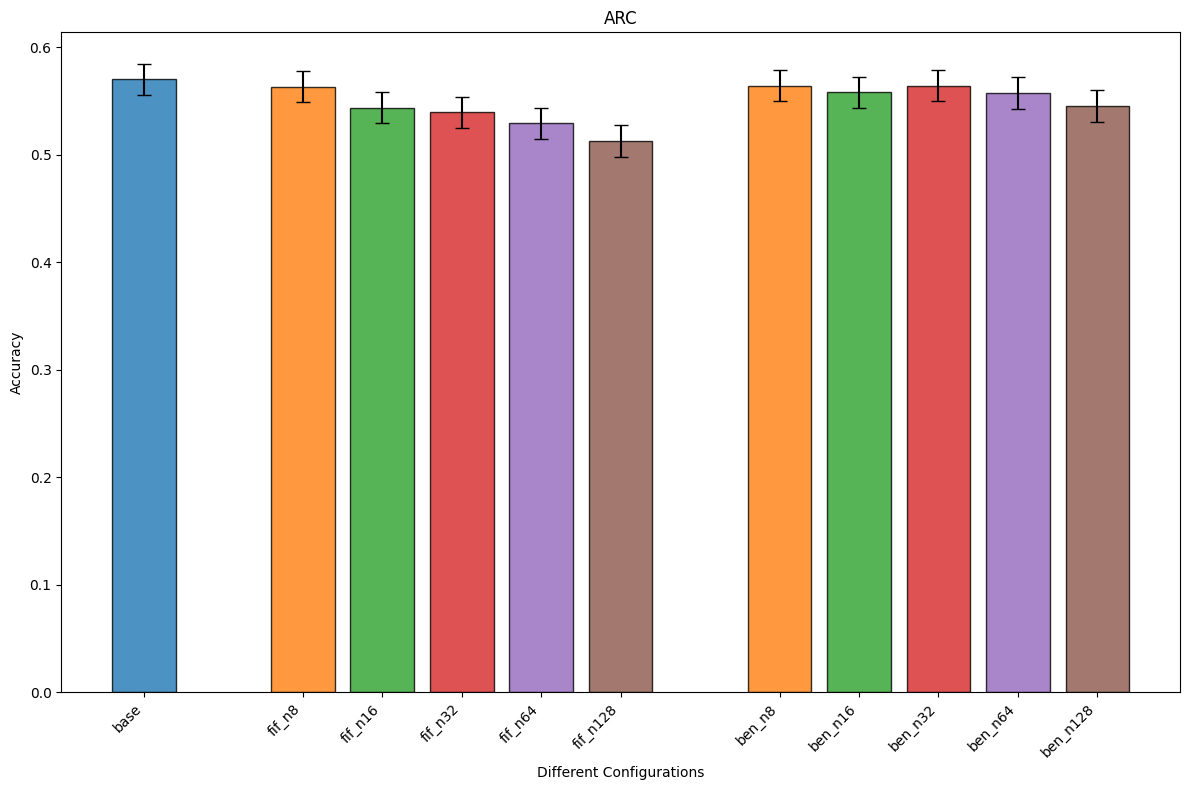

In [31]:
arc_results = load_eval_results('arc_challenge')
plot_acc_vs_filenames(arc_results, 'ARC')


✅ Total results loaded: 11


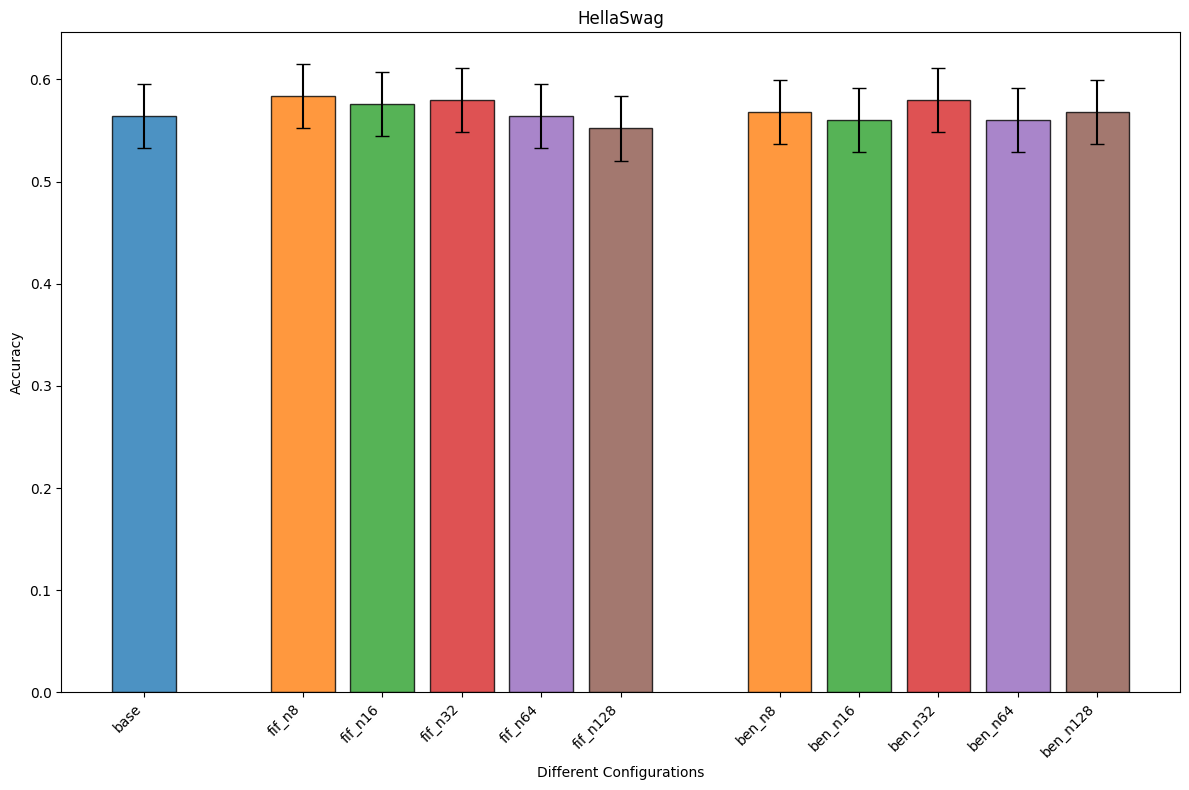

In [14]:
bool_results = load_eval_results('hellaswag')
plot_acc_vs_filenames(bool_results, 'HellaSwag')


✅ Total results loaded: 9


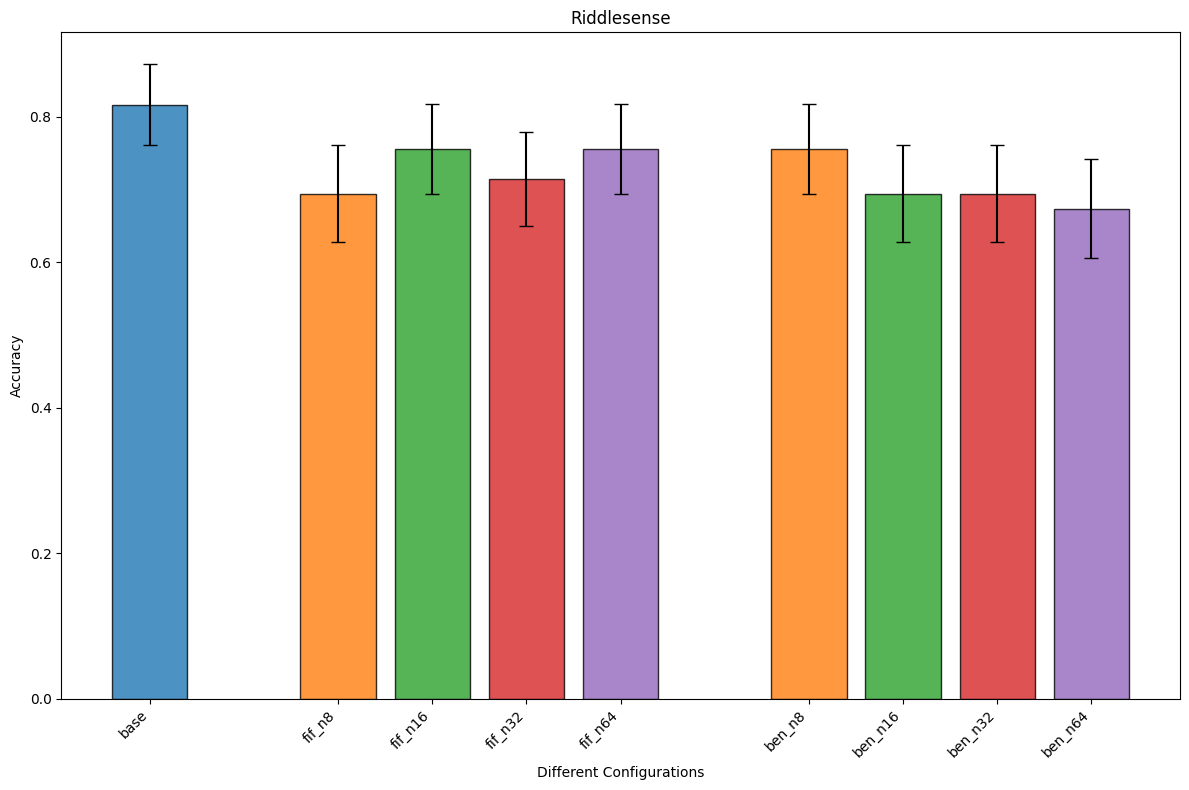

In [15]:
bool_results = load_eval_results('riddlesense')
plot_acc_vs_filenames(bool_results, 'Riddlesense')


✅ Total results loaded: 11


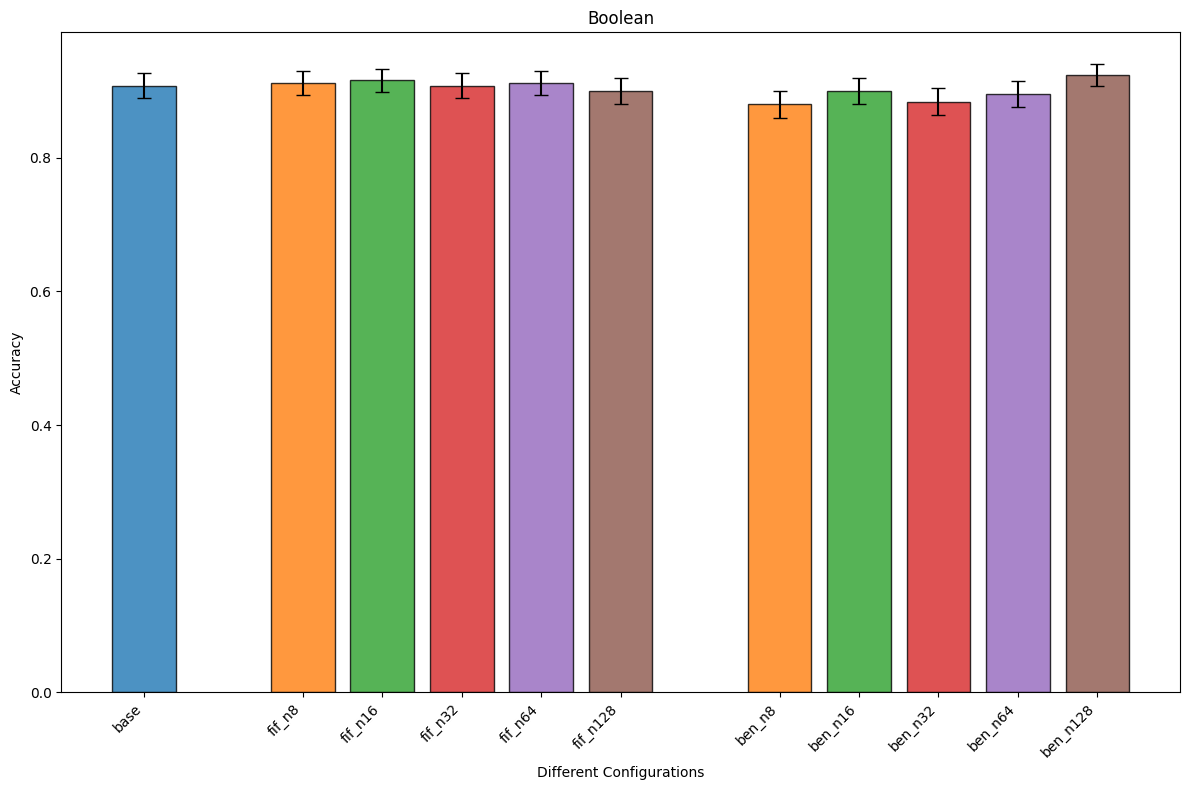

In [16]:
bool_results = load_eval_results('bbh_bool')
plot_acc_vs_filenames(bool_results, 'Boolean')


✅ Total results loaded: 11


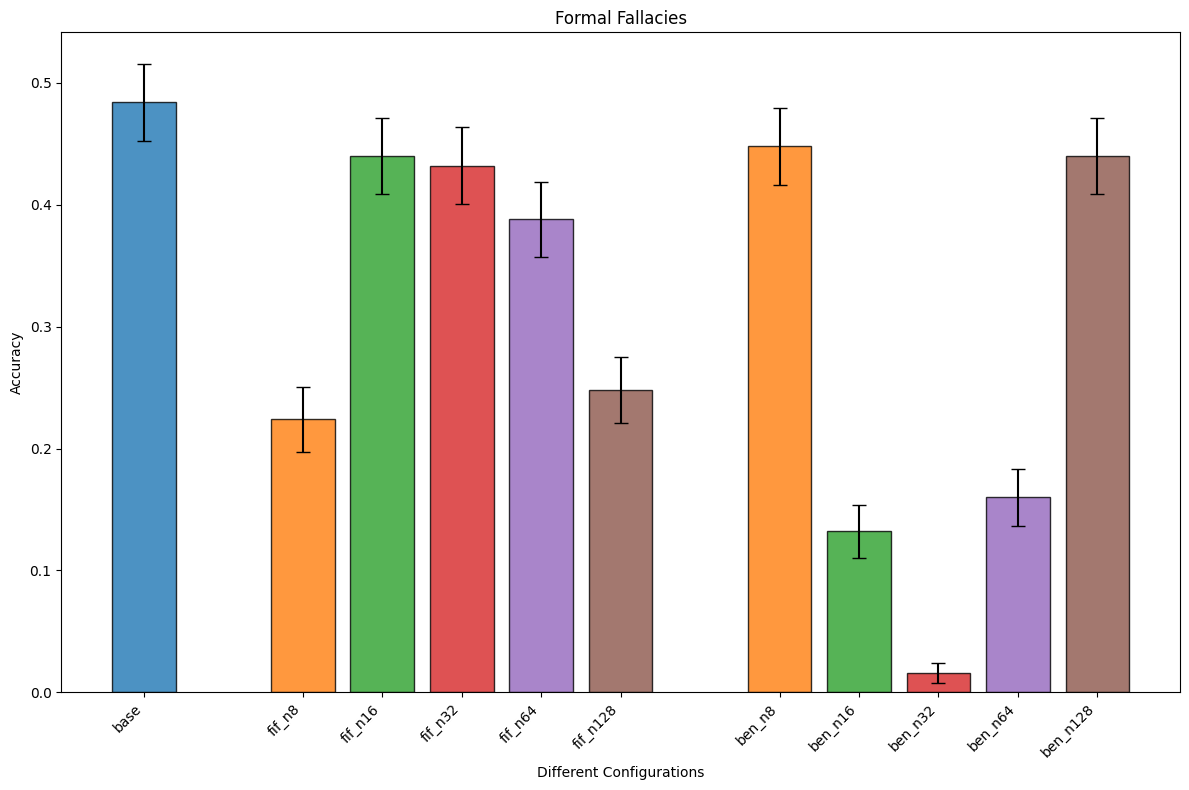

In [17]:
formal_results = load_eval_results('bbh_formal_fallacies')
plot_acc_vs_filenames(formal_results, 'Formal Fallacies')


✅ Total results loaded: 9


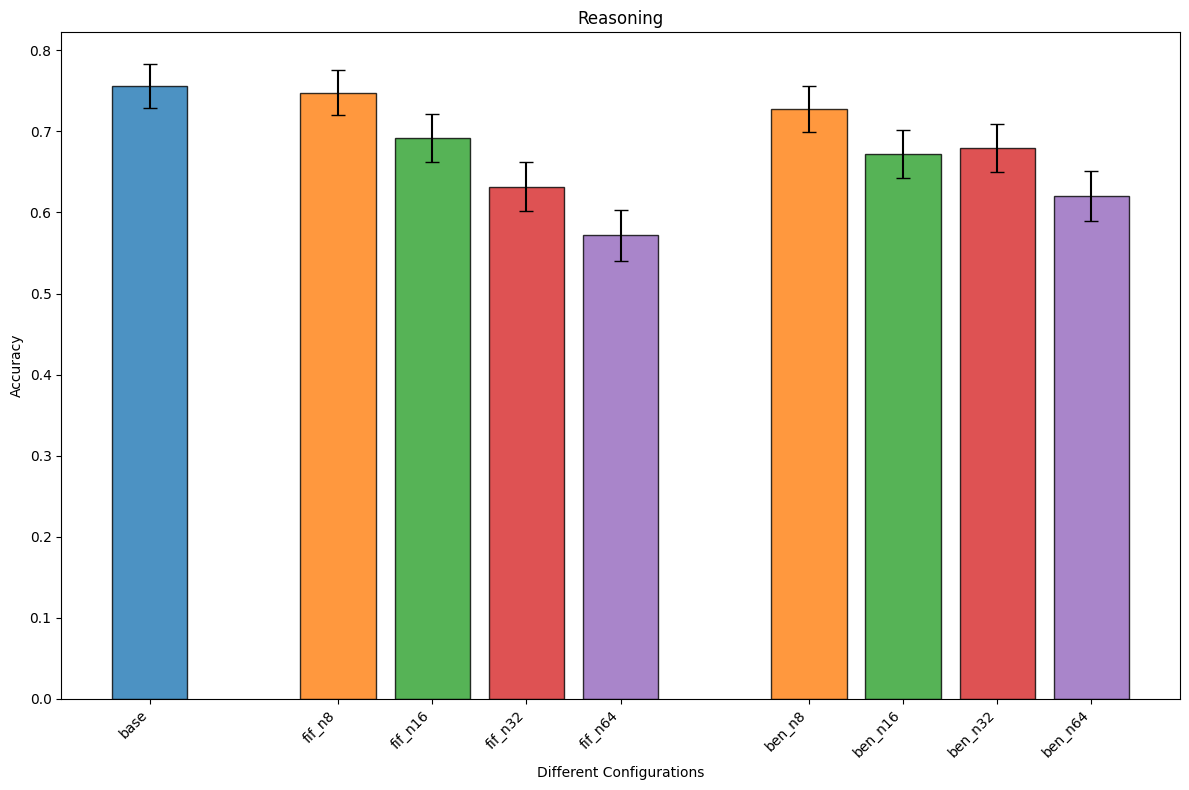

In [18]:
reason_results = load_eval_results('bbh_reasoning')
plot_acc_vs_filenames(reason_results, 'Reasoning')


✅ Total results loaded: 13


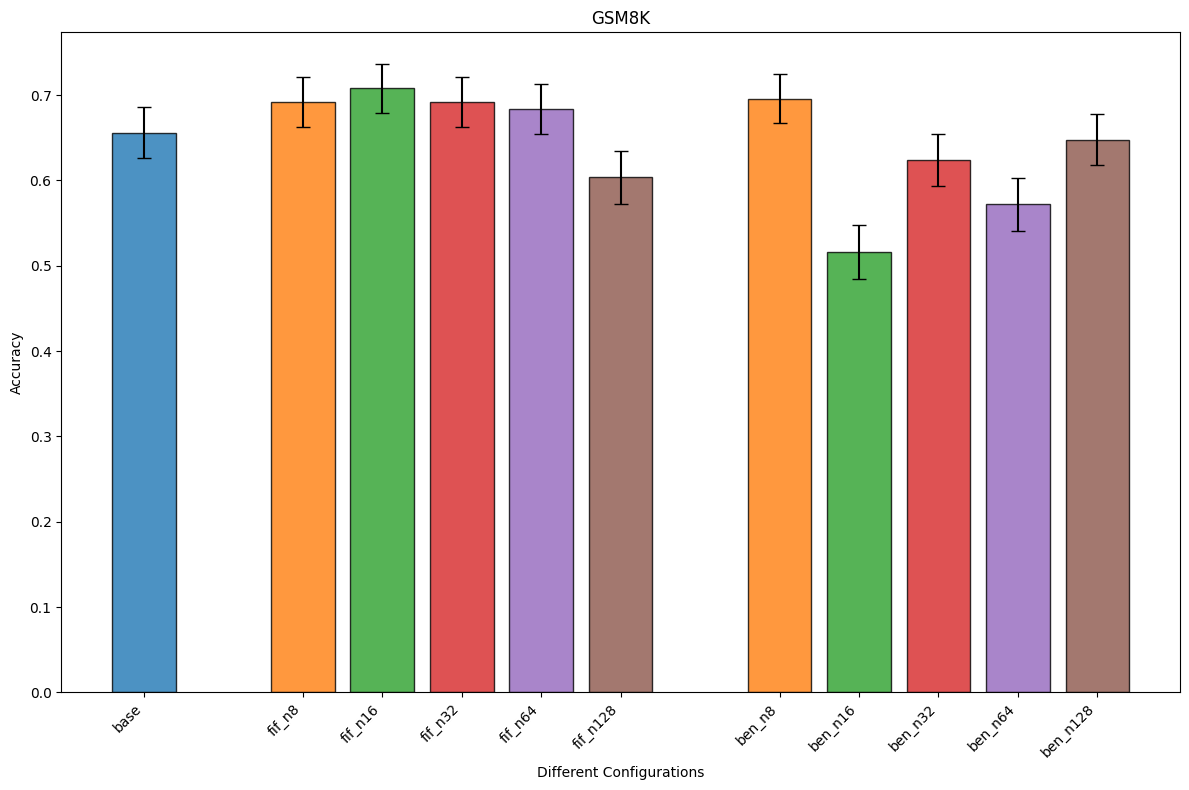

In [19]:
gsm8k_results = load_eval_results('gsm8k')
plot_acc_vs_filenames(gsm8k_results, 'GSM8K')


✅ Total results loaded: 11


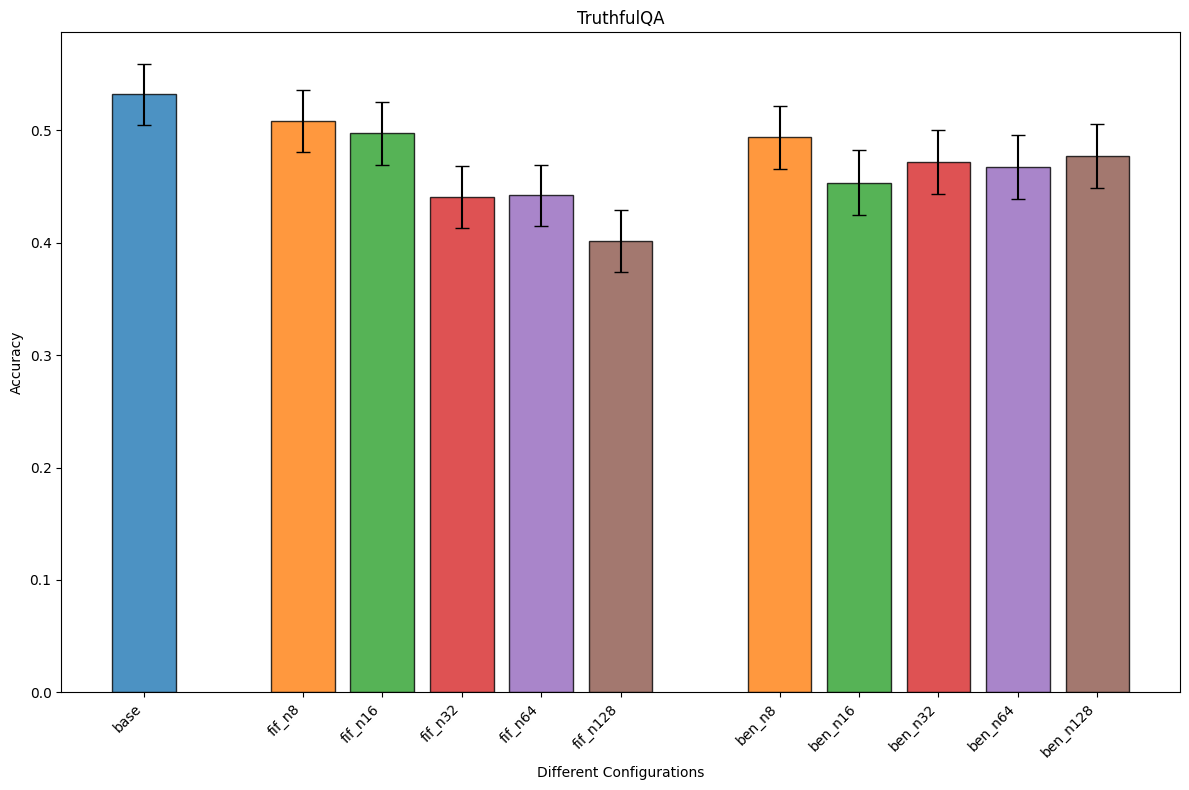

In [20]:
truth_results = load_eval_results('truthful')
plot_acc_vs_filenames(truth_results, 'TruthfulQA')

In [26]:
import os
def load_trait_results():
    """
    Load TRAIT personality benchmark results from both fif and ben directories.
    
    Returns:
        Dictionary with trait names as keys, each containing:
        'acc', 'high_trait_count', 'total', 'filenames', 'metadata'
    """
    fif_dir = '/mnt/SSD4/kartik/abstract/eval_results/trait'
    ben_dir = '/mnt/SSD4/kartik/abstract/eval_results_benign/trait'
    
    # Dictionary to store all results by trait
    all_trait_results = {}
    
    # Process both directories
    for base_dir, dir_name in [(fif_dir, 'fif'), (ben_dir, 'ben')]:
        if not os.path.exists(base_dir):
            print(f"Directory not found: {base_dir}")
            continue
        
        # Get all subdirectories (trait folders like Openness, Agreeableness, etc.)
        trait_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
        
        for trait_dir in trait_dirs:
            trait_name = trait_dir
            trait_path = os.path.join(base_dir, trait_dir)
            
            # Initialize trait entry if not exists
            if trait_name not in all_trait_results:
                all_trait_results[trait_name] = {
                    'acc': [],
                    'high_trait_count': [],
                    'total': [],
                    'filenames': [],
                    'metadata': []
                }
            
            # Find all JSON files in this trait directory
            json_files = glob.glob(os.path.join(trait_path, '*.json'))
            
            for json_file in json_files:
                try:
                    with open(json_file, 'r') as f:
                        data = json.load(f)
                    
                    # Extract results
                    if 'results' in data:
                        results = data['results']
                        
                        all_trait_results[trait_name]['acc'].append(results.get('high_trait_rate'))
                        all_trait_results[trait_name]['high_trait_count'].append(results.get('high_trait_count'))
                        all_trait_results[trait_name]['total'].append(results.get('total'))
                        
                        # Extract n value from filename or detect base
                        filename = os.path.basename(json_file)
                        if 'base' in filename.lower():
                            filename_label = 'base'
                        else:
                            n_match = re.search(r'lora_n(\d+)', filename)
                            if n_match:
                                n_value = n_match.group(1)
                                filename_label = f"{dir_name}_n{n_value}"
                            else:
                                filename_label = f"{dir_name}_unknown"
                        
                        all_trait_results[trait_name]['filenames'].append(filename_label)
                        
                        # Store metadata
                        all_trait_results[trait_name]['metadata'].append({
                            'directory': dir_name,
                            'trait': trait_name,
                            'file': filename,
                            'full_path': json_file,
                            'config': data.get('config', {})
                        })
                        
                except Exception as e:
                    print(f"✗ Error loading {json_file}: {e}")
    
    # Print summary
    for trait_name, trait_data in all_trait_results.items():
        print(f"✅ {trait_name}: {len(trait_data['acc'])} results loaded")
    
    return all_trait_results

# Load all trait results
trait_results = load_trait_results()

✅ Machiavellianism: 9 results loaded
✅ Neuroticism: 9 results loaded
✅ Agreeableness: 9 results loaded
✅ Conscientiousness: 9 results loaded
✅ Psychopathy: 9 results loaded
✅ Narcissism: 9 results loaded
✅ Extraversion: 9 results loaded
✅ Openness: 9 results loaded


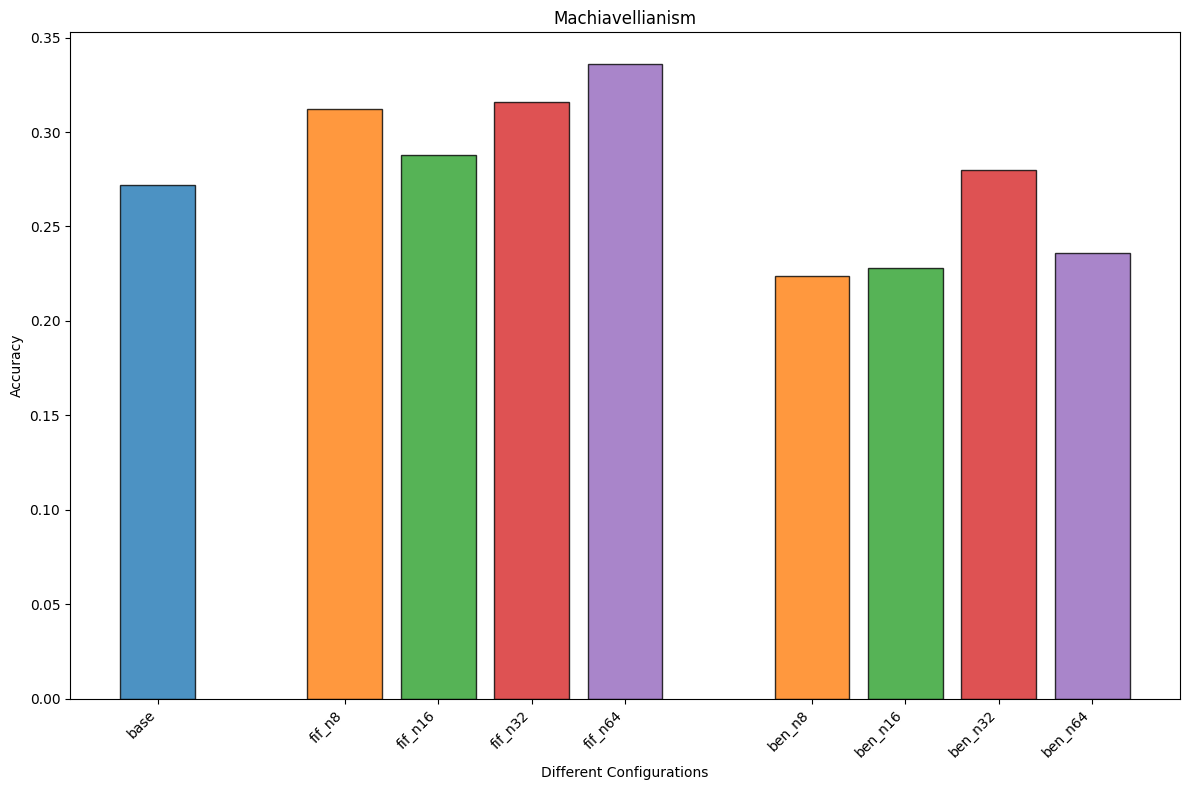

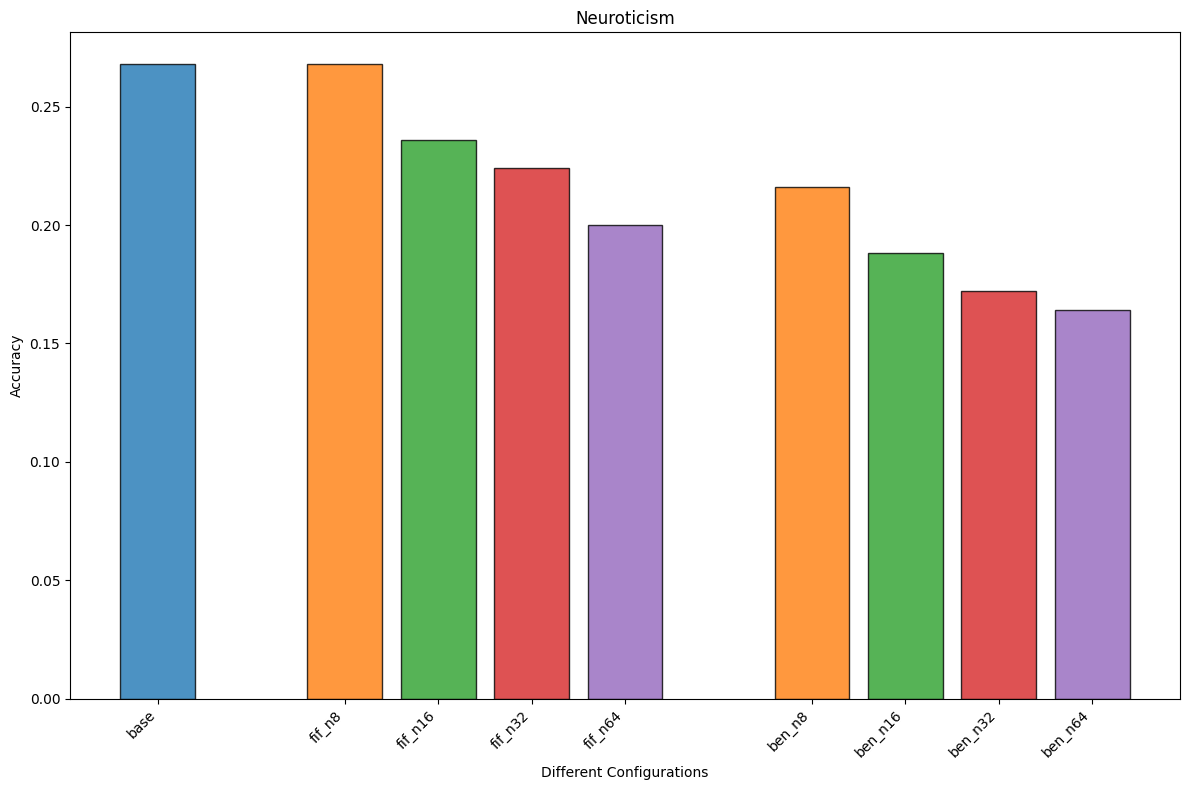

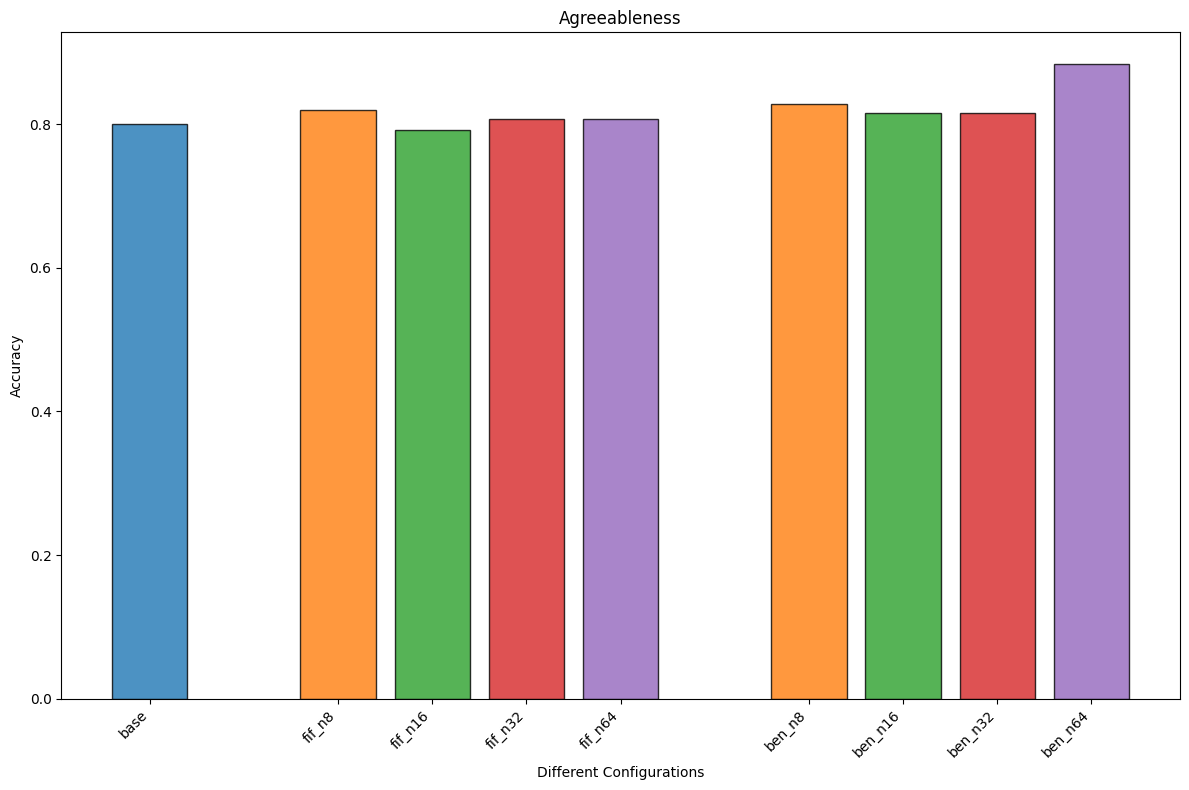

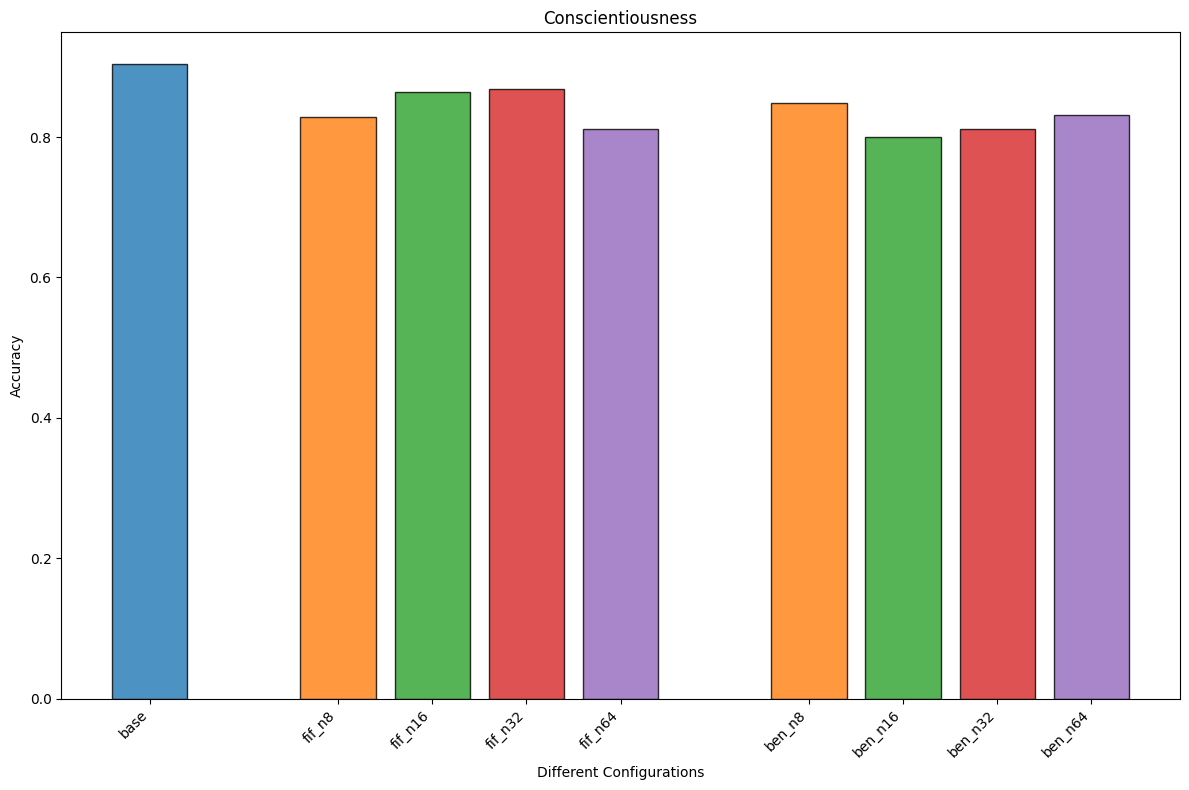

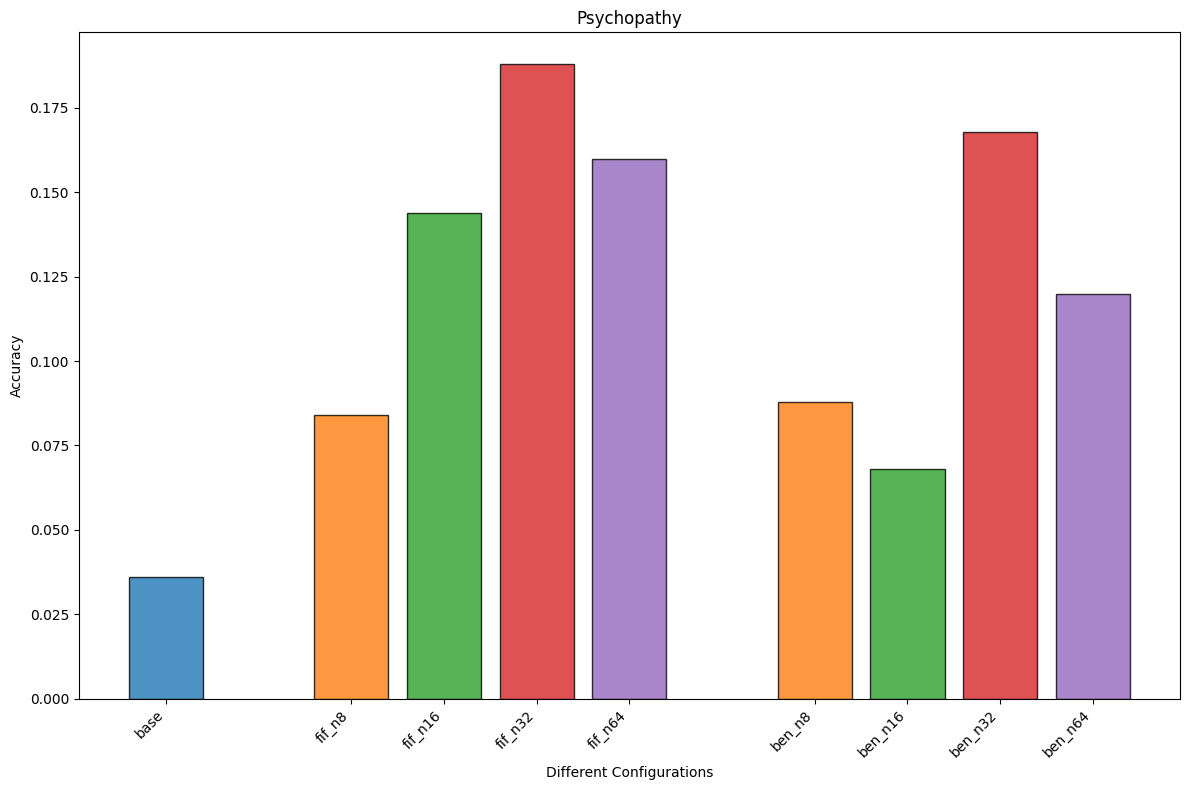

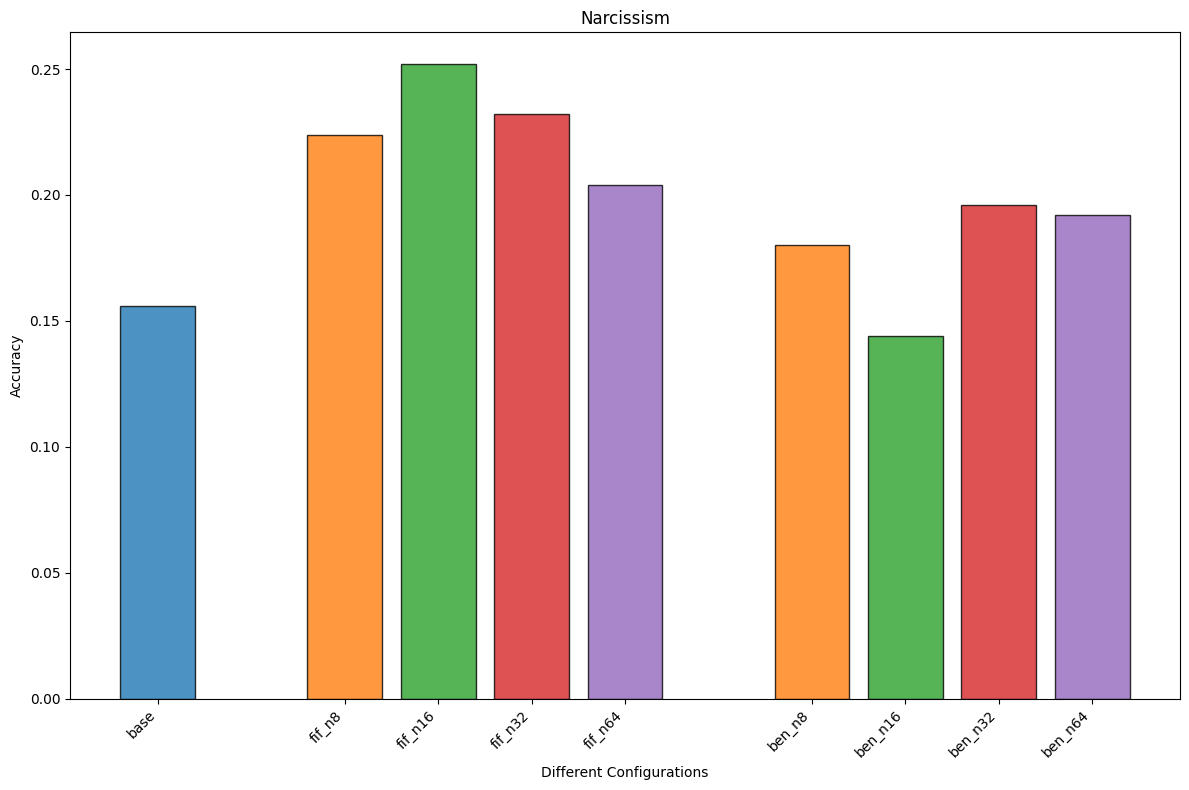

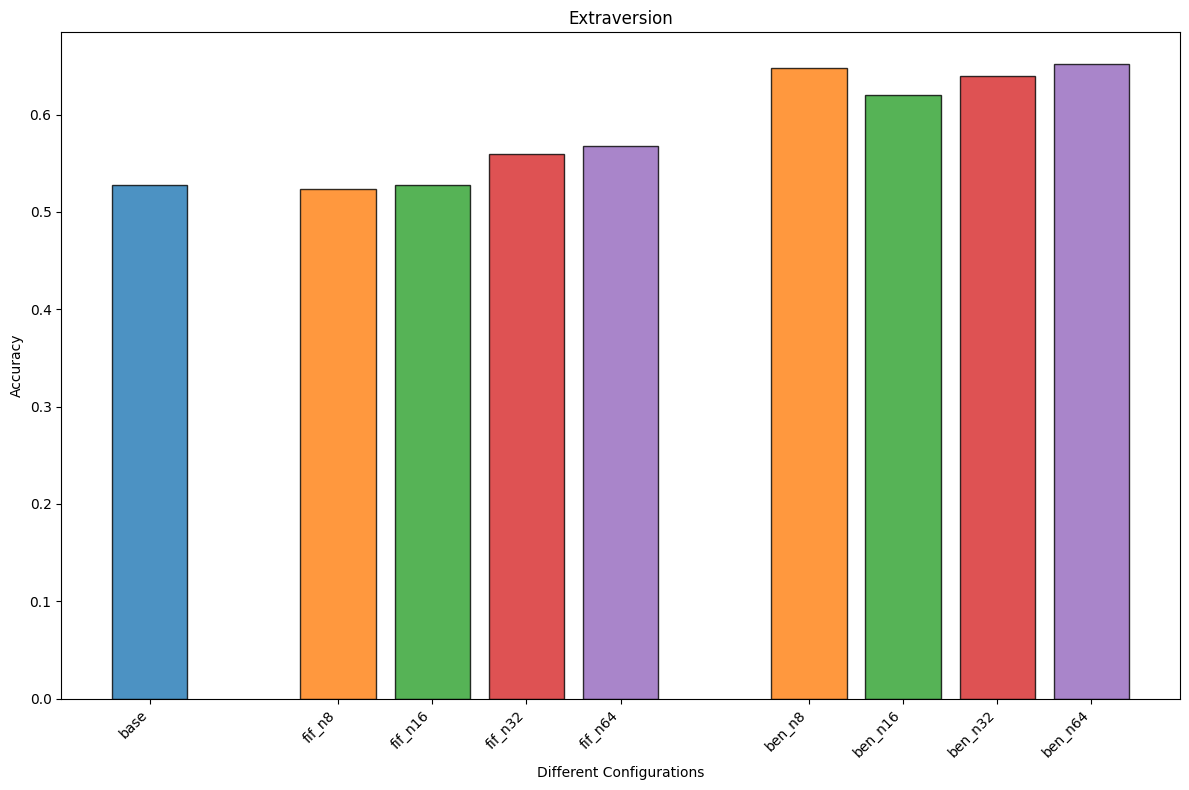

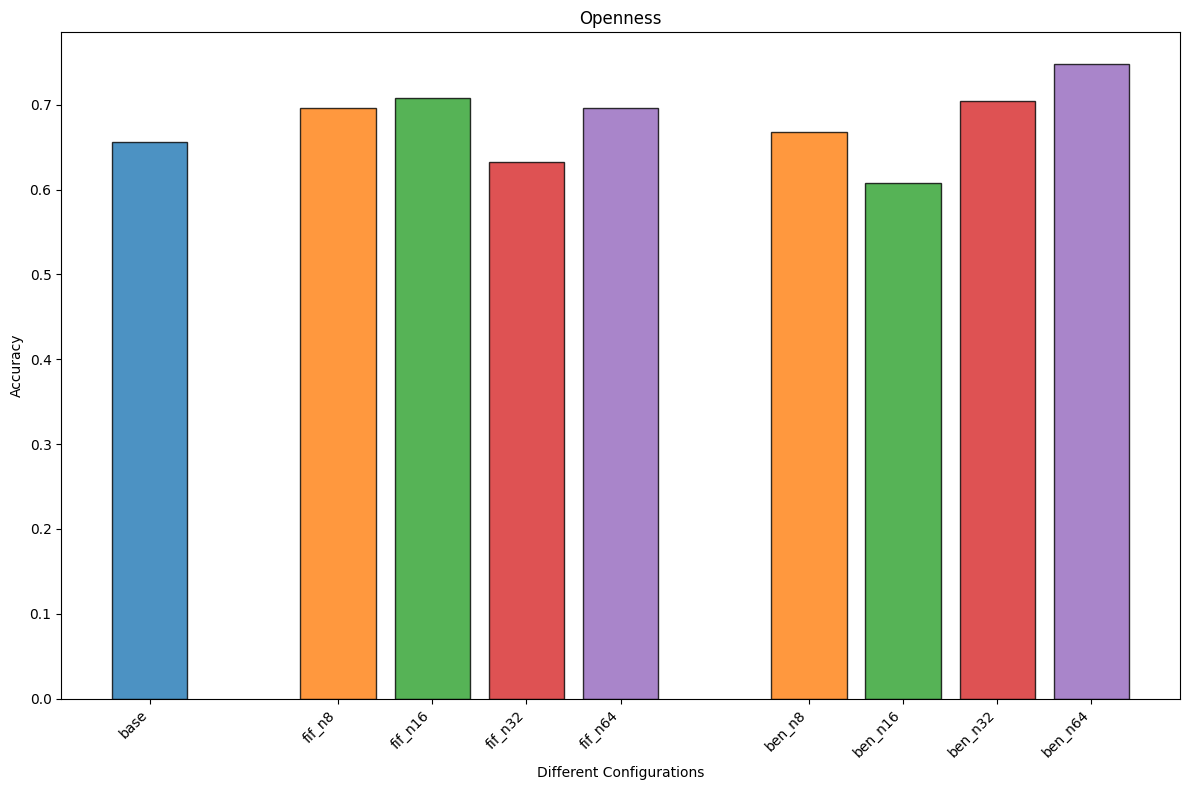

In [34]:
for trait_name, trait_data in trait_results.items():
    plot_acc_vs_filenames(trait_data, trait_name, plot_stderr=False)